# One-qudit: High-dimensional phase estimation

In [ ]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import seaborn as sns
import ultraplot as uplt
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import Wire
from squint.ops.dv import DiscreteVariableState, HGate, RZGate

In [ ]:
dim = 4
wire = Wire(dim=dim, idx=0)

circuit = Circuit()

circuit.add(DiscreteVariableState(wires=(wire,), n=(0,)))
circuit.add(HGate(wires=(wire,)))
circuit.add(RZGate(wires=(wire,), phi=0.1 * jnp.pi), "phase")
circuit.add(HGate(wires=(wire,)))

params, static = eqx.partition(circuit, eqx.is_inexact_array)

print("The full circuit object:")
pprint(circuit)

print("The parameterized leaves of the Pytree:")
pprint(params)

print("The static leaves of the Pytree:")
pprint(static)

In [ ]:
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(static, params, optimize="greedy")

In [11]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(lambda pytree: pytree.ops["phase"].phi, params, phis)

probs = jax.vmap(sim.probabilities.forward)(params)
grads = jax.vmap(sim.probabilities.grad)(params).ops["phase"].phi
qfims = jax.vmap(sim.amplitudes.qfim)(params)
cfims = jax.vmap(sim.probabilities.cfim)(params)

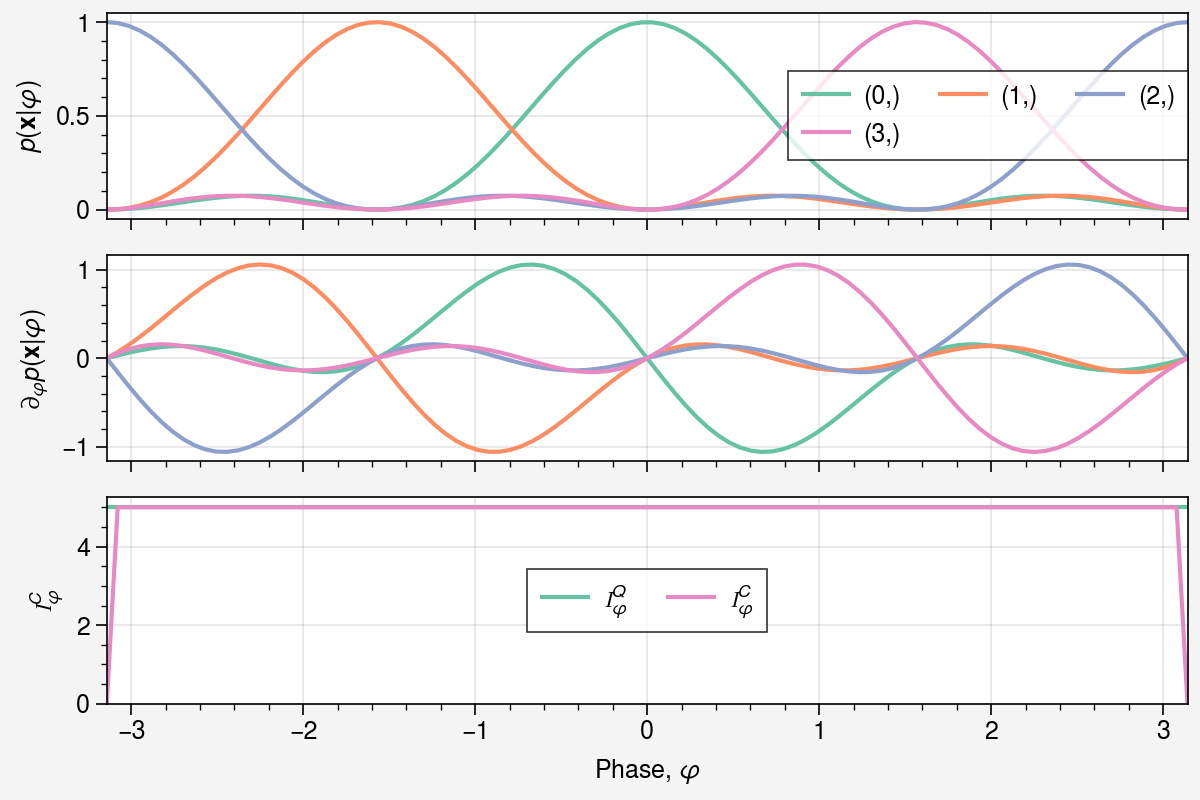

In [13]:
colors = sns.color_palette("Set2", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = uplt.subplots(nrows=3, figsize=(6, 4), sharey=False)

for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])

    axs[1].plot(phis, grads[:, *idx], label=f"{idx}", color=colors[i])
axs[0].legend()
axs[0].set(ylabel=r"$p(\mathbf{x} | \varphi)$")
axs[1].set(ylabel=r"$\partial_{\varphi} p(\mathbf{x} | \varphi)$")

axs[2].plot(phis, qfims.squeeze(), color=colors[0], label=r"$\mathcal{I}_\varphi^Q$")
axs[2].plot(phis, cfims.squeeze(), color=colors[-1], label=r"$\mathcal{I}_\varphi^C$")
axs[2].set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)
axs[2].legend();